# Simulating convection

In [1]:
from pyro import Pyro
from pyro import compressible

We can model convection in a 2D plane-parallel atmosphere using [pyro](https://python-hydro.github.io/pyro2).

The `convection` problem setup initializes an isentropic atmosphere in hydrostatic equilibrium.  The density at the base of the atmosphere is `convection.dens_base` and the density falls to a value `convection.dens_cutoff`.  In regions above the atmosphere, the density is set to this cutoff value.  This _buffer_ region gives the atmosphere room to expand as heat is injected.

We'll setup this problem using the [unsplit compressible solver](https://python-hydro.github.io/pyro2/compressible_basics.html#compressible-solver).

We can override the defaults of any of the runtime parameters by adding them to the `params` dictionary here:

In [2]:
p = Pyro("compressible")
params = {"mesh.nx": 96, "mesh.ny": 288}
p.initialize_problem("convection", inputs_dict=params)

The `convection` problem sets up a source term to the energy evolution equation of the form:

$$\frac{\partial (\rho E)}{\partial t} + \nabla \cdot (\rho {\bf U}E + {\bf U}p) = \rho {\bf U} \cdot {\bf g} + \rho S$$

where $S$ is the heating source (energy / mass / time).  We take the form:

$$S = {f}_\mathrm{heat} e^{-((y - y_0)/\sigma)^2}$$

where $y_0$ is the vertical location of the heating layer (controlled by `convection.y_height`), $\sigma$ is the thickness of the heating layer (controlled by `convection.thickness`), and $f_\mathrm{heat}$ is the amplitude of the heating rate (controlled by `convection.e_rate`).

We can inspect this source

In [3]:
compressible.problems.convection.source_terms??

Signature: compressible.problems.convection.source_terms(myg, U, ivars, rp)
Source:   
def source_terms(myg, U, ivars, rp):
    """source terms to be added to the evolution"""

    S = myg.scratch_array(nvar=ivars.nvar)

    y_height = rp.get_param("convection.y_height")

    dist = np.abs(myg.y2d - y_height)

    e_rate = rp.get_param("convection.e_rate")
    thick = rp.get_param("convection.thickness")

    S[:, :, ivars.iener] = U[:, :, ivars.idens] * e_rate * np.exp(-(dist / thick)**2)
    return S
File:      /raid/zingale/development/pyro2/pyro/compressible/problems/convection.py
Type:      function

Finally, we can see the value of all parameters that control this problem:

In [4]:
print(p)

Solver = compressible
Problem = convection
Simulation time = 0.0
Simulation step number = 0

Runtime Parameters
------------------
compressible.cvisc = 0.1
compressible.delta = 0.33
compressible.grav = -2.0
compressible.limiter = 2
compressible.riemann = HLLC
compressible.small_dens = 0.0001
compressible.small_eint = -1e+200
compressible.use_flattening = 1
compressible.z0 = 0.75
compressible.z1 = 0.85
convection.dens_base = 1000.0
convection.dens_cutoff = 0.001
convection.e_rate = 0.5
convection.scale_height = 2.0
convection.thickness = 0.25
convection.y_height = 2.0
driver.cfl = 0.8
driver.fix_dt = -1.0
driver.init_tstep_factor = 0.01
driver.max_dt_change = 2.0
driver.max_steps = 100000
driver.tmax = 25.0
driver.verbose = 0
eos.gamma = 1.4
io.basename = convection_
io.do_io = 0
io.dt_out = 0.5
io.force_final_output = 0
io.n_out = 100000000
mesh.grid_type = Cartesian2d
mesh.nx = 96
mesh.ny = 288
mesh.xlboundary = periodic
mesh.xmax = 4.0
mesh.xmin = 0.0
mesh.xrboundary = periodic
mesh.

Let's view the initial state:

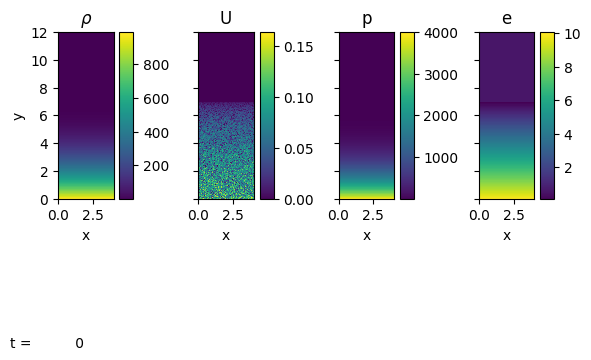

<Figure size 640x480 with 0 Axes>

In [5]:
p.sim.dovis()

We see that the initial velocity is just set as random noise--this will break the symmetry and start the convection.

Now we'll run the simulation.  We can do step-by-step if desired, but here we'll just run to the maximum time we asked (`driver.tmax`).

```{note}
This can take a while, depending on your computer.  If it is too slow, you can try lowering the resolution (`mesh.nx` and `mesh.ny`) even more that we already did above.
```

In [6]:
p.run_sim()

Now we see that considerable convection has set in.  We are using a very coarse resolution here, so there is not much fine structure, but we see largescale velocity features.

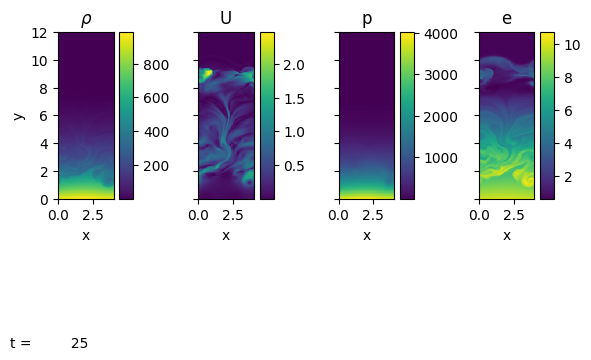

<Figure size 640x480 with 0 Axes>

In [7]:
p.sim.dovis()

Since we are stratified, it is hard to see the detail in the energy field.  Let's instead look at the departure from the background value,

$$e' = e - \langle e \rangle$$

where the average $\langle \cdot \rangle$ is over all cells at a constant height.

We'll normalize this by $e$ so we see the relative fluctuation.

In [8]:
import numpy as np

In [9]:
e = p.get_var("e")
e_avg = np.average(e, axis=0)
eprime_scaled = np.abs((e - e_avg[np.newaxis, :]) / e)

```{note}
pyro wraps NumPy arrays to provide additional methods for working with ghost cells
and doing stencil operations.  See: [ArrayIndexer](https://python-hydro.github.io/pyro2/mesh-examples.html#ArrayIndexer)
```

In [12]:
import matplotlib.pyplot as plt

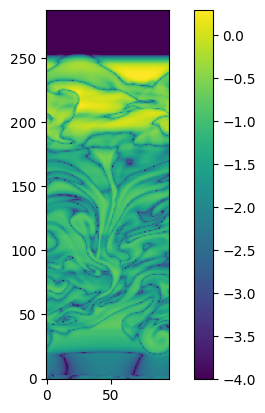

In [13]:
fig, ax = plt.subplots()
im = ax.imshow(np.log10(eprime_scaled.v().T), origin="lower", vmin=-4)
fig.colorbar(im, ax=ax)

This shows that the departure from the background energy is small, but not zero.